<a href="https://colab.research.google.com/github/OleksiiLatypov/Regression_of_Used_Car_Prices/blob/main/used_car_price_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e9:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F76728%2F9057646%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240914%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240914T183307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D94a6da211f95857ee004528fa741db3be1cff436ebdbbf1909564d1ab02f496731f95127a2a962e5bfc2cb9777527b276f0ba8dae16840fff51113fe7f7fd17946a78a007492a700d2aabca5e63114a495bfe6ff60373c922f1a804741e85dfa50e909a0626d49aed58b9d4f008cbad9183b5548595c0ef3874737850e852950c7c85d7eb438d9fe483f13947f01f039284d505bcd131f1b8249c6ed7196a71c5c3e4948df203755423f9afcbbfe6d833b7c5e1a24e97a2e466d9d13d29ea5606fb8c4530d6e409fdd03a86d13d53bed0c4b22861a248bbd3e524ac831aa03080d4cfa31ddc7915d405dbd40472ea811ae1c9c17b1399b7d763ac9ef960eeafa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8223535 bytes downloaded
Downloaded and uncompressed: playground-series-s4e9
Data source import complete.


In [ ]:
!pip install category_encoders

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import re
from datetime import datetime
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, LinearRegression
import category_encoders as ce

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/test.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/sample_submission.csv


In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [6]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [7]:
train.shape

(188533, 12)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [9]:
test.shape

(125690, 11)

In [10]:
train['engine'][35:95]

,engine
35,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
36,248.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
37,563.0HP 5.5L 8 Cylinder Engine Gasoline Fuel
38,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
39,3.6L V6 24V GDI DOHC
40,230.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
41,450.0HP 6.7L 8 Cylinder Engine Diesel Fuel
42,430.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
43,4.0L V8 32V GDI DOHC Twin Turbo
44,835.0HP Electric Motor Electric Fuel System


In [11]:
train.describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


In [12]:
train.describe(include='object')

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


In [13]:
100* (train.isna().sum() / len(train)).sort_values(ascending=False)

,0
clean_title,11.360876
fuel_type,2.696080
accident,1.300568
brand,0.000000
model,0.000000
model_year,0.000000
milage,0.000000
engine,0.000000
transmission,0.000000
ext_col,0.000000


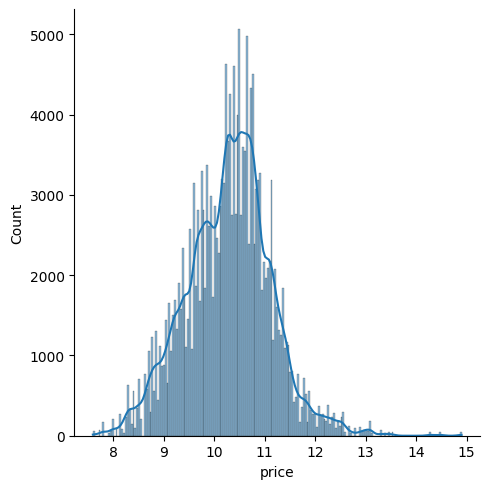

In [14]:
sns.displot(np.log(train['price']), kde=True)

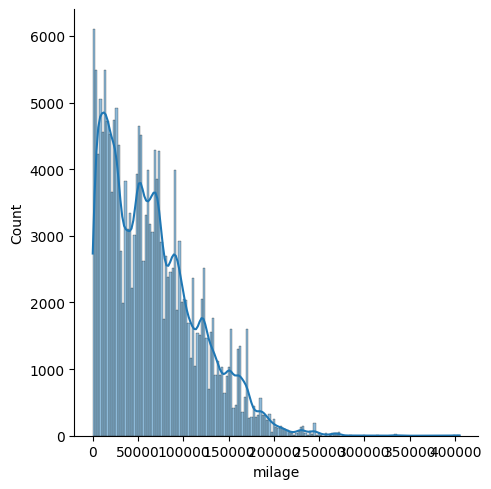

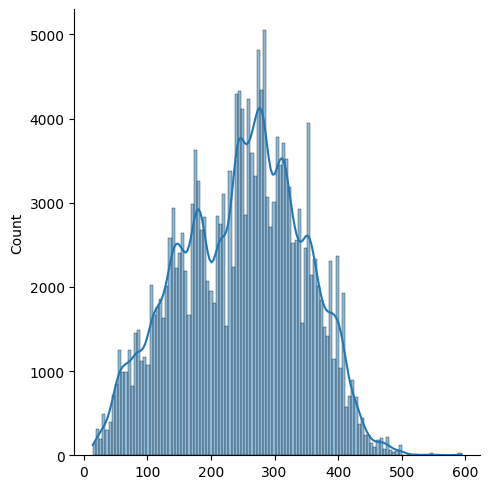

In [44]:
from scipy import stats
milage = train['milage']
milage_boxcox, _ = stats.boxcox(milage + 1)

sns.displot(train['milage'], kde=True)
sns.displot(milage_boxcox, kde=True)

In [46]:
train['milage'] = milage_boxcox

In [15]:
train['clean_title'].value_counts()

,count
clean_title,
Yes,167114


In [47]:
df = pd.concat([train, test], axis=0, ignore_index=True)

In [48]:
df['brand'].unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota',
       'Hyundai', 'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM',
       'Hummer', 'Alfa', 'INFINITI', 'Jeep', 'Porsche', 'McLaren',
       'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia',
       'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn',
       'Bentley', 'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini',
       'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma',
       'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury',
       'Polestar', 'Maybach'], dtype=object)

In [49]:
avarage_price_by_brand = train.groupby('brand')['price'].agg(['mean', 'median'])
avarage_price_by_brand.sort_values(by='median', ascending=False).astype('int')

,mean,median
brand,,
Bugatti,169600,220000
Lamborghini,159176,102000
McLaren,123261,87500
Rivian,81089,78000
Rolls-Royce,135488,77500
Ferrari,116751,75500
Bentley,129272,73600
Aston,112364,67650
Lucid,63310,56000


In [50]:
lux_auto = [
    "Mercedes-Benz",
    "Audi",
    "BMW",
    "Tesla",
    "Cadillac",
    "Land Rover",
    "Porsche",
    "Lexus",
    "INFINITI",
    "Jaguar",
    "Rolls-Royce",
    "Bentley",
    "Ferrari",
    "Aston Martin",
    "Lamborghini",
    "Bugatti",
    "Maserati",
    "Lucid",
    "Polestar",
    "Maybach",
    "Lincoln"
]

In [51]:
df['premium_auto'] = df['brand'].apply(lambda x: 1 if x in lux_auto else 0)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,premium_auto
0,MINI,Cooper S Base,2007,450.068087,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,0
1,Lincoln,LS V8,2002,379.198846,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,1
2,Chevrolet,Silverado 2500 LT,2002,371.642767,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,0
3,Genesis,G90 5.0 Ultimate,2017,159.693101,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,0
4,Mercedes-Benz,Metris Base,2021,104.467957,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,1


In [52]:
horsepower = []
engine_volume = []
num_of_cylinders = []
for row in df['engine']:
    #print(row)
    hp = re.search(r'(\d+\.?\d*)HP', row)
    #print(hp)
    if hp:
        horsepower.append(float(hp.group(1)))
    else:
        horsepower.append(0)

    volume = re.search(r'(\d+\.?\d*)L', row)
    if volume:
        engine_volume.append(float(volume.group(1)))
    else:
        engine_volume.append(0)

    cylinder = re.search(r'(\d+)\s*Cylinder|V(\d+)', row, re.IGNORECASE)

    if cylinder:
        # If we find a numeric cylinder, use that
        if cylinder.group(1):
            num_of_cylinders.append(float(cylinder.group(1)))
        # If we find a V-style code, use the number after 'V'
        elif cylinder.group(2):
            num_of_cylinders.append(float(cylinder.group(2)))
    else:
        # If no match is found, default to 0
        num_of_cylinders.append(0)

df['horsepower'] =horsepower
df['engine_volume'] = engine_volume
df['num_of_cylinders'] = num_of_cylinders


In [ ]:
#df[35:62]

In [53]:
df['num_of_cylinders'].nunique()

8

In [54]:
df[df['fuel_type'] == 'not supported']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,premium_auto,horsepower,engine_volume,num_of_cylinders
4823,Chevrolet,Suburban LT,2011,337.814783,not supported,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Beige,None reported,Yes,18998.0,0,320.0,5.3,8.0
18000,Porsche,Camaro 2SS,2015,272.960019,not supported,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,11500.0,1,240.0,2.0,4.0
19182,Nissan,Mirai Limited,2000,364.828401,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Silver,Black,None reported,Yes,5000.0,0,182.0,0.0,0.0
27199,Subaru,Outback 2.5i Limited,2017,346.144615,not supported,175.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,CVT Transmission,Gray,Black,At least 1 accident or damage reported,Yes,27499.0,0,175.0,2.5,4.0
33030,Nissan,Mirai Limited,2009,372.349035,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,12999.0,0,182.0,0.0,0.0
60717,Chevrolet,Silverado 1500 RST,2020,158.617865,not supported,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,58000.0,0,355.0,5.3,8.0
74096,Toyota,Mirai Limited,2021,294.547639,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Red,Black,None reported,Yes,15000.0,0,182.0,0.0,0.0
86897,Lexus,IS 350 F Sport,2022,116.644855,not supported,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,60000.0,1,311.0,3.5,6.0
94425,Porsche,Cayenne Turbo GT,2018,244.567869,not supported,550.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Gray,At least 1 accident or damage reported,Yes,35000.0,1,550.0,4.8,8.0
127066,Toyota,Mirai Limited,2016,257.690918,not supported,151.0HP Electric Motor Hydrogen Fuel,CVT Transmission,Black,Black,At least 1 accident or damage reported,Yes,22500.0,0,151.0,0.0,0.0


In [55]:
to_replace = []
for row in df.loc[df['fuel_type'] == 'not supported', 'engine']:
    fuel = re.search(r'(Gasoline|Diesel|Hybrid|Flex Fuel|Electric|Plug-In Hybrid)', row)
    if fuel.group(1) == 'Flex Fuel':
        to_replace.append('E85 Flex Fuel')
    else:
        to_replace.append(fuel.group(1))
print(to_replace)

['E85 Flex Fuel', 'Gasoline', 'Electric', 'Gasoline', 'Electric', 'Gasoline', 'Electric', 'Gasoline', 'Gasoline', 'Electric', 'Gasoline', 'Electric', 'Gasoline', 'Gasoline', 'Electric', 'Electric', 'Gasoline', 'Gasoline', 'Electric', 'Electric', 'Electric', 'Gasoline', 'E85 Flex Fuel', 'Gasoline', 'Electric', 'Electric', 'Gasoline', 'Gasoline', 'Electric']


In [56]:
df.loc[df['fuel_type'] == 'not supported', 'fuel_type'] = to_replace

In [57]:
df['fuel_type'].value_counts()

,count
fuel_type,
Gasoline,276487
Hybrid,11508
E85 Flex Fuel,8931
Diesel,6641
–,1319
Plug-In Hybrid,858
Electric,13


In [58]:
df.loc[df['fuel_type'] == 'not supported', 'fuel_type']

,fuel_type


In [59]:
df[pd.isna(df['fuel_type'])].shape

(8466, 16)

In [60]:
df['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'Electric'], dtype=object)

In [61]:
fuel = df[pd.isna(df['fuel_type'])]
type_of_fuel = []
for col in fuel['engine']:
    #print(col)
    if 'Hybrid' in col:
        type_of_fuel.append('Hybrid')
        #print('hybrid')
    elif 'Gasoline' in col:
        type_of_fuel.append('Gasoline')
        #print('gas')
    elif 'Flex Fuel' in col:
        type_of_fuel.append('E85 Flex Fuel')
        #print('flex')
    elif 'Diesel' in col:
        type_of_fuel.append('Diesel')
        #print('diesel')
    else:
        type_of_fuel.append('Electric')

print(len(type_of_fuel))

nan_indices = df[pd.isna(df['fuel_type'])].index
df.loc[nan_indices, 'fuel_type'] = type_of_fuel

8466


In [62]:
df['age'] = datetime.now().year - df['model_year']

In [63]:
df['transmission'].value_counts()

,count
transmission,
A/T,83036
8-Speed A/T,34586
Transmission w/Dual Shift Mode,32079
6-Speed A/T,30105
6-Speed M/T,19863
7-Speed A/T,18498
Automatic,17866
8-Speed Automatic,13977
10-Speed A/T,13347


In [64]:
df[df['transmission'] == 'Single-Speed Fixed Gear']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,premium_auto,horsepower,engine_volume,num_of_cylinders,age
4520,Bentley,Bentayga Speed,2020,168.311274,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,Single-Speed Fixed Gear,Beluga Black,Hotspur,None reported,Yes,113990.0,1,0.0,6.0,0.0,4
29512,Porsche,Taycan,2020,59.593651,Electric,Electric,Single-Speed Fixed Gear,Gray,Beige,None reported,NaN,90998.0,1,0.0,0.0,0.0,4
37921,Porsche,Taycan Turbo,2022,71.812943,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,Gray,Black,None reported,Yes,89900.0,1,0.0,0.0,0.0,2
39107,Porsche,Taycan Turbo,2020,59.593651,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,Gray,–,None reported,NaN,94998.0,1,0.0,0.0,0.0,4
40412,Mercedes-Benz,Taycan 4S,2023,124.815233,Gasoline,Dual AC Electric Motors,Single-Speed Fixed Gear,BLACK,Black,None reported,NaN,51700.0,1,0.0,0.0,0.0,1
66211,Porsche,Taycan Turbo,2021,124.761054,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,BLACK,BEIGE,None reported,NaN,27671.0,1,0.0,0.0,0.0,3
87851,Porsche,Taycan Base,2020,60.103040,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,Silver,Black,None reported,NaN,44998.0,1,0.0,0.0,0.0,4
96877,Porsche,Taycan Turbo,2020,165.028405,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,BLACK,BEIGE,None reported,NaN,61998.0,1,0.0,0.0,0.0,4
102992,Porsche,Taycan Turbo,2022,75.858720,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,Gentian Blue Metallic,Black,None reported,NaN,78350.0,1,0.0,0.0,0.0,2
108580,Porsche,Taycan Turbo,2022,59.593651,Electric,Dual AC Electric Motors,Single-Speed Fixed Gear,Black,Black,None reported,NaN,76598.0,1,0.0,0.0,0.0,2


In [65]:
num_of_speed = []
type_trans = []
for row in df['transmission']:
#     speed = re.search(r'(\d+)\s*[-/]*\s*Speed', row, re.IGNORECASE)
#     if speed:
#         num_of_speed.append(float(speed.group(1)))
#     else:
#         num_of_speed.append(0)
    if ('Automatic' in row) or ('A/T' in row) or ('AT' in row)\
    or ('A/t' in row) or ('Transmission Overdrive Switch' in row):
        type_trans.append('A')
    elif 'DCT' in row or 'Transmission w/Dual Shift Mode' in row:
        type_trans.append('DCT')
    elif 'CVT' in row or 'CVT-F':
        type_trans.append('CVT')
    elif 'Variable' in row:
        type_trans.append('Variable')
    elif 'Single-Speed Fixed Gear' in row:
        type_trans.append('Single-Speed Fixed Gear')
    elif 'F' in row:
        type_trans.append('F')
    elif 'At/Mt' in row:
        type_trans.append('At/Mt')
    elif '–' in row:
        type_trans.append('Unknown')
    else:
        type_trans.append('M')


print(len(num_of_speed))
print(len(type_trans))


0
314223


In [35]:
df['transmission'] = type_trans
#df['num_of_speed'] = num_of_speed

In [ ]:
#df[df['transmission'] == 'Transmission w/Dual Shift Mode']

In [66]:
df['accident'] = df['accident'].fillna(df['accident'].mode()[0])

In [67]:
df.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


In [68]:
df = df.drop(['clean_title'], axis=1)

In [69]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,premium_auto,horsepower,engine_volume,num_of_cylinders,age
0,MINI,Cooper S Base,2007,450.068087,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200.0,0,172.0,1.6,4.0,17
1,Lincoln,LS V8,2002,379.198846,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999.0,1,252.0,3.9,8.0,22
2,Chevrolet,Silverado 2500 LT,2002,371.642767,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,13900.0,0,320.0,5.3,8.0,22
3,Genesis,G90 5.0 Ultimate,2017,159.693101,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,45000.0,0,420.0,5.0,8.0,7
4,Mercedes-Benz,Metris Base,2021,104.467957,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,97500.0,1,208.0,2.0,4.0,3


In [ ]:
# df['speed'] = df['transmission'].str.extract('(\d+)-Speed', expand=False)
# df['speed'] = df['speed'].fillna(df['transmission'].str.extract('(\d+)-Speed', expand=False))
# df['speed'] = df['speed'].fillna(df['transmission'].str.extract('(\d+) Speed', expand=False))
# df['speed'] = df['speed'].fillna(df['transmission'].str.extract('(\d+) ', expand=False))
# df['speed'] = df['speed'].fillna(df['transmission'].str.extract('^(\d+)', expand=False))

In [ ]:
# cat_columns = df.select_dtypes(include=['object'])
# missing_cols = [col for col in cat_columns.columns if cat_columns[col].isna().any()]
#missing_cols = ['fuel_type', 'accident']

In [ ]:
# for col in missing_cols:
#     df.loc[:, col] = df.loc[:, col].fillna(df.loc[:, col].mode()[0])

In [ ]:
#df['clean_title'] = df['clean_title'].fillna('No')
#df = df.drop('clean_title', axis=1)

In [ ]:
# X_columns = df[['brand', 'model']]
# y_target = df['price']

# encoder = ce.TargetEncoder(cols=['brand', 'model'], smoothing=0.3)
# X_encoded = encoder.fit_transform(X_columns, y_target)
# df_encoded = pd.concat([X_encoded, y], axis=1)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder with handle_unknown='use_encoded_value'
# and specify the value to be used for unknown categories
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder on training data
#df['model_encoded'] = ordinal_encoder.fit_transform(df[['model']])
df['ext_col']=ordinal_encoder.fit_transform(df[['ext_col']])
df['int_col']=ordinal_encoder.fit_transform(df[['int_col']])

In [ ]:
#df = df.drop('model', axis=1)

In [ ]:
# df['brand'] = df_encoded['brand']
# df['model'] = df_encoded['model']

In [ ]:
df['int_col'].unique()

In [ ]:
df.head()

In [ ]:
# encoder=LabelEncoder()
# # df['brand']=encoder.fit_transform(df['brand'])
# # df['model']=encoder.fit_transform(df['model'])
# #df['fuel_type']=encoder.fit_transform(df['fuel_type'])
# df['ext_col']=encoder.fit_transform(df['ext_col'])
# df['int_col']=encoder.fit_transform(df['int_col'])
# #train['accident']=encoder.fit_transform(train['accident'])
# #df['clean_title']=encoder.fit_transform(df['clean_title'])

import category_encoders as ce

encoder = ce.CountEncoder()

# Apply CountEncoder to each categorical column
df['brand'] = encoder.fit_transform(df['brand'])
df['model'] = encoder.fit_transform(df['model'])
df['transmission'] = encoder.fit_transform(df['transmission'])
df['engine'] = encoder.fit_transform(df['engine'])
df['fuel_type'] = encoder.fit_transform(df['fuel_type'])
df['ext_col'] = encoder.fit_transform(df['ext_col'])
df['int_col'] = encoder.fit_transform(df['int_col'])

df.head()

In [ ]:
df = pd.get_dummies(df, dtype='int')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.head()

In [70]:
train_df = df.iloc[:188533, :]
test_df = df.iloc[188533:, :]

In [71]:
X = train_df.copy()

In [72]:
y = np.log(X['price'])
X = X.drop('price', axis=1)

In [73]:
y

,price
0,8.342840
1,8.516993
2,9.539644
3,10.714418
4,11.487608
...,...
188528,10.221941
188529,10.308953
188530,11.372513
188531,11.349229


In [74]:
cbe_encoder = ce.cat_boost.CatBoostEncoder(a=1)
X_encoded = cbe_encoder.fit_transform(X, y)

In [ ]:
!pip install catboost

In [77]:
# #for test split 0.3 is the best !!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from catboost import CatBoostRegressor


clf_catboost = CatBoostRegressor(iterations=275,
                                  learning_rate=0.03,
                                  depth=7,
                                 l2_leaf_reg=3,
                                border_count=254,
                                 verbose=0)  # verbose=0 to suppress output during cross-validation


# Define k-fold cross-validation
n_splits = 7  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(clf_catboost, X_encoded, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

clf_catboost.fit(X_encoded, y)
#72823 = 700iter
#72718 = 300iter

Mean RMSE: 0.4955
Standard Deviation of RMSE: 0.0039


In [78]:
test_df = test_df.drop('price', axis=1)

In [79]:
test_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,premium_auto,horsepower,engine_volume,num_of_cylinders,age
188533,Land,Rover LR2 Base,2015,98000.0,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,0,240.0,2.0,4.0,9
188534,Land,Rover Defender SE,2020,9142.0,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,0,395.0,3.0,6.0,4
188535,Ford,Expedition Limited,2022,28121.0,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,0,0.0,3.5,6.0,2
188536,Audi,A6 2.0T Sport,2016,61258.0,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,1,0.0,0.0,0.0,8
188537,Audi,A6 2.0T Premium Plus,2018,59000.0,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,1,252.0,2.0,4.0,6


In [80]:
test_X_encoded = cbe_encoder.transform(test_df)

In [81]:
test_X_encoded.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,premium_auto,horsepower,engine_volume,num_of_cylinders,age
188533,10.530028,9.656025,2015,98000.0,10.270395,9.793159,9.912374,10.268266,9.904338,10.424538,0,240.0,2.0,4.0,9
188534,10.530028,11.053962,2020,9142.0,10.671869,11.021359,10.670964,9.970823,10.374648,10.424538,0,395.0,3.0,6.0,4
188535,10.285014,10.663146,2022,28121.0,10.270395,10.689658,10.784351,10.268266,10.571496,10.424538,0,0.0,3.5,6.0,2
188536,10.307170,10.184267,2016,61258.0,10.270395,10.621747,10.784222,10.987197,10.374648,10.424538,1,0.0,0.0,0.0,8
188537,10.307170,10.034504,2018,59000.0,10.270395,10.217286,9.962087,10.430995,10.374648,10.424538,1,252.0,2.0,4.0,6


In [82]:
test_id = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
predictions = clf_catboost.predict(test_X_encoded)
test_id['price'] = np.exp(predictions)
test_id.to_csv('submission_FE_catboost_1_log.csv', index=False)

In [83]:
test_id

,id,price
0,188533,12824.494786
1,188534,37836.432405
2,188535,35438.810227
3,188536,19597.099259
4,188537,20667.973021
...,...,...
125685,314218,17137.996954
125686,314219,33969.581754
125687,314220,11692.023223
125688,314221,11494.596286


In [84]:
y_hat = clf_catboost.predict(X_encoded)[:10]
np.exp(y_hat)

array([ 8325.67068117, 10197.76575822, 11184.94911384, 42836.55240605,
       48809.64476619, 32940.59099352, 27984.22693354, 24127.21985934,
       37024.84974541, 27115.18848851])

In [85]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Define the XGBoost regressor
clf_xgboost = XGBRegressor(n_estimators=700,
                           learning_rate=0.01,
                           max_depth=6,
                           reg_alpha=3,
                           n_jobs=-1,  # Use all available cores
                           verbose=0)  # Suppress output during cross-validation

# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(clf_xgboost, X_encoded, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

# Fit the model on the entire dataset
clf_xgboost.fit(X_encoded, y)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, Use

Mean RMSE: 0.4925
Standard Deviation of RMSE: 0.0011


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [86]:
y_xgb = clf_xgboost.predict(X_encoded)
np.exp(y_xgb)[:10]

array([ 8325.836,  9480.054, 12205.05 , 43809.62 , 60949.406, 31270.803,
       27725.855, 24566.137, 38612.11 , 28880.217], dtype=float32)

In [87]:
train_df['price'].head(10)

,price
0,4200.0
1,4999.0
2,13900.0
3,45000.0
4,97500.0
5,29950.0
6,28500.0
7,12500.0
8,62890.0
9,4000.0


In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from lightgbm import LGBMRegressor
import numpy as np

# Initialize the LGBMRegressor model
clf_lightgbm = LGBMRegressor(n_estimators=3000,
                             learning_rate=0.01,
                             max_depth=5,
                             #reg_alpha=3,
                             #num_leaves=31,
                             verbose=-1)  # verbose=-1 to suppress output during cross-validation

# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(clf_lightgbm, X_encoded, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE (LightGBM): {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE (LightGBM): {std_rmse:.4f}")

# Fit the LightGBM model to the training data
clf_lightgbm.fit(X_encoded, y)


In [99]:
y_lgbm = clf_lightgbm.predict(X_encoded[:10])
np.exp(y_lgbm)

array([ 7078.6127208 ,  8280.39433796, 11733.21082325, 43629.62863755,
       65438.54980406, 30128.72085939, 26363.5207329 , 23016.61426891,
       36033.12604492, 26868.02363425])

In [90]:
train_df['price'].head(10)

,price
0,4200.0
1,4999.0
2,13900.0
3,45000.0
4,97500.0
5,29950.0
6,28500.0
7,12500.0
8,62890.0
9,4000.0


# DONT TOCH THIS BELOW

In [ ]:
# #for test split 0.3 is the best !!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from catboost import CatBoostRegressor


clf_catboost = CatBoostRegressor(iterations=700,
                                 learning_rate=0.0311,
                                 depth=6,
                                 l2_leaf_reg=3,
                                # border_count=100,
                                 verbose=0)  # verbose=0 to suppress output during cross-validation


# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(clf_catboost, X, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

clf_catboost.fit(X, y)

In [ ]:
# test_df = test_df.drop('price', axis=1)

In [ ]:
test.head()

In [ ]:
test_dataset = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [ ]:
(100* (test_dataset.isna().sum())/len(test_dataset)).sort_values(ascending=False)

In [ ]:
test_dataset = test_dataset.drop('clean_title', axis=1)

In [ ]:
missing_columns = ['fuel_type', 'accident']

In [ ]:
for col in missing_columns:
    test_dataset.loc[:, col] = test_dataset.loc[:, col].fillna(test_dataset.loc[:, col].mode()[0])

In [ ]:
encoder=LabelEncoder()
test_dataset['brand']=encoder.fit_transform(test_dataset['brand'])
test_dataset['model']=encoder.fit_transform(test_dataset['model'])
#df['fuel_type']=encoder.fit_transform(df['fuel_type'])
test_dataset['engine']=encoder.fit_transform(test_dataset['engine'])
test_dataset['transmission']=encoder.fit_transform(test_dataset['transmission'])
test_dataset['ext_col']=encoder.fit_transform(test_dataset['ext_col'])
test_dataset['int_col']=encoder.fit_transform(test_dataset['int_col'])
test_dataset['accident']=encoder.fit_transform(test_dataset['accident'])

In [ ]:
test_dataset = pd.get_dummies(test_dataset, dtype='int')

In [ ]:
test_dataset.head()

In [ ]:
test_id = test_dataset['id']

In [ ]:
test_dataset = test_dataset.drop('id', axis=1)

In [ ]:
# submit = pd.read_csv("/kaggle/input/playground-series-s4e9/sample_submission.csv")
# pred = clf_catboost.predict(test_df)
# submit["price"] = pred
# submit.to_csv("submission.csv", index=False)
# submit.head()

In [ ]:
#test_id = test_dataset['id']
test_predictions_catboost = clf_catboost.predict(test_dataset)
print(test_predictions_catboost[:10])
# Prepare submission
test_predictions_catboost_df = pd.DataFrame(test_predictions_catboost, columns=['price'])
submit_df = pd.concat([test_id, test_predictions_catboost_df], axis=1)
submit_df.to_csv('submission_1.csv', index=False)

In [ ]:
submit_df.head()

In [ ]:
train_predictions_catboost = clf_catboost.predict(X.iloc[:10, :])
train_predictions_catboost

In [ ]:
# train.head()

In [ ]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
sample.head()